In [18]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf, ceil, floor
from scipy.stats import norm, pearsonr
from scipy.stats.mstats import gmean

from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from time import perf_counter
import gc

""" Plt font size """
plt.rcParams['font.size'] = '13'

Time per 10,000 samples = 3.09 sec

# Part 1

In [2]:
""" Euler's Method """
def gbm_euler(S0, r, sigma, T, M, path_simulation=False):
    zm = norm.rvs(loc=0., scale=1, size=M)
    dt = T / M
    Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
    for m in range(1, M+1):
        Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
        Sm[m, 1] = m * dt
    if path_simulation:
        return Sm
    return Sm[-1,0]

<AxesSubplot:title={'center':'Simulated Stock Movement Using Geometric Brownian Motion'}, xlabel='Time', ylabel='Stock Price'>

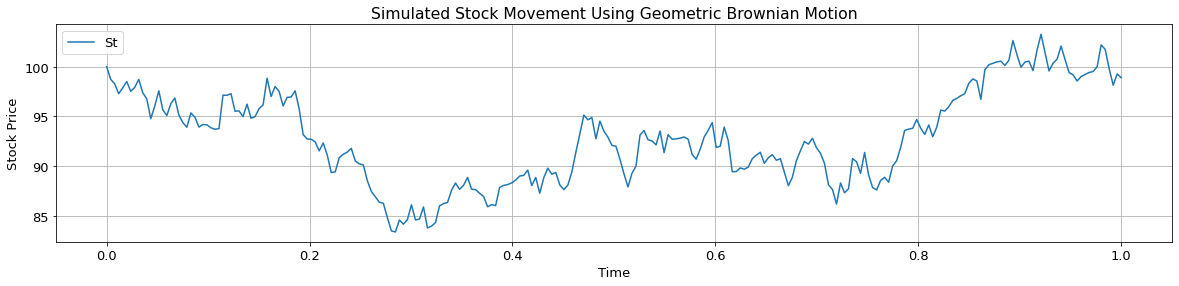

In [179]:
""" Geometric Brownian Motion - St Simulation"""
S0 = 100
sigma = .20
r = 0.06
T = 1.
M = 253
output = gbm_euler(S0, r, sigma, T, M, path_simulation=True)

temp_output = pd.DataFrame(output, columns=['St', 'Time'])
temp_output = temp_output.set_index('Time')
temp_output.plot(figsize=(20,4), grid=True, title="Simulated Stock Movement Using Geometric Brownian Motion", ylabel="Stock Price", label=f'Euler Method M={M}')

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Payoff Distribution and Convergence for Different Number of Paths (M)

100%|██████████| 100000/100000 [00:20<00:00, 4913.50it/s]


Probability of tbe option expiring in the Money = 40.16000 %
Expected Payoff = 4.79460 EUR 
Standard Deviation of E(Payoff) = 8.48866 EUR


Text(0.5, 0, 'Payoff of Put Option (EUR)')

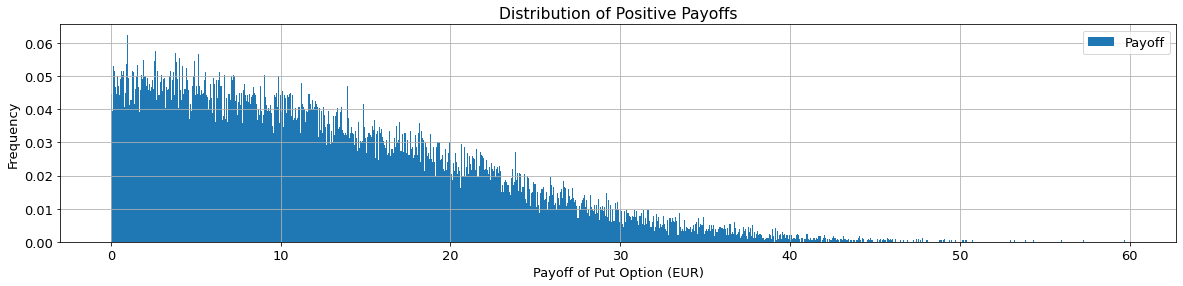

In [182]:
simulations = 100_000
payoff_dist = np.empty(simulations)
for inx in trange(simulations):
    K = 99 ; N = 254
    payoff_dist[inx] = max(K- gbm_euler(S0, r, sigma, T, N), 0)

print(f'Probability of tbe option expiring in the Money = {payoff_dist[payoff_dist > 0].shape[0] / simulations *100:.5f} %')
print(f'Expected Payoff = {payoff_dist.mean()*np.exp(-r*T):.5f} EUR \nStandard Deviation of E(Payoff) = {payoff_dist.std():.5f} EUR')
ax = pd.DataFrame(payoff_dist[payoff_dist>0], columns=['Payoff']).plot(kind='hist', bins=1000, density=True, figsize=(20,4), grid=True, title="Distribution of Positive Payoffs")
ax.set_xlabel('Payoff of Put Option (EUR)')

In [7]:
""" Bootstrapping Technique """
def bootstrapping(M, K = 99, sigma = 0.2, SE_report=False):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    S0 = 100
    # sigma = .20
    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2)))
        zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
        for _inx in range(M):
            _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx]), 0) * np.exp(-r*T)

    if SE_report:
        return np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])
    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])

In [8]:
start_M = 10    ;   end_M = 1_000_000 ;   points_in_graph = 30

M_values = np.logspace(start=np.log10(start_M), stop=np.log10(end_M), num=points_in_graph, base=10)

""" Creates a DataFrame to fill with values """
results_convergence_df = pd.DataFrame(np.zeros((points_in_graph, 2)), index=M_values , columns=['Expected Payoff - Put Option', 'Standard Error'])
results_convergence_df.index.name = 'Number of Paths (M)'

for M in tqdm(M_values):
    results_convergence_df.loc[M, :] = bootstrapping(M) # returns: mean, SE

results_convergence_df

100%|██████████| 30/30 [09:01<00:00, 18.04s/it]


,Expected Payoff - Put Option,Standard Error
Number of Paths (M),,
10.000000,6.540352,1.103841
14.873521,4.917794,4.015362
22.122163,7.468241,1.102258
32.903446,3.459980,1.146471
48.939009,3.860229,1.234609
72.789538,4.959473,0.989928
108.263673,3.988774,0.671822
161.026203,4.935967,0.573552
239.502662,4.793499,0.348876


In [7]:
BS_analytical_solution = 4.778969051891707
print(f'Expected Payoff = {(results_convergence_df.iloc[-1, 0] - BS_analytical_solution)/BS_analytical_solution * 100:.5f} %')
print(f'Percentage Difference from Analytical Solution = {(results_convergence_df.iloc[-1, 0] - BS_analytical_solution)/BS_analytical_solution * 100:.5f} %')

Expected Payoff = -0.09291 %
Percentage Difference from Analytical Solution = -0.09291 %


Text(0, 0.5, 'Standard Error (SE)')

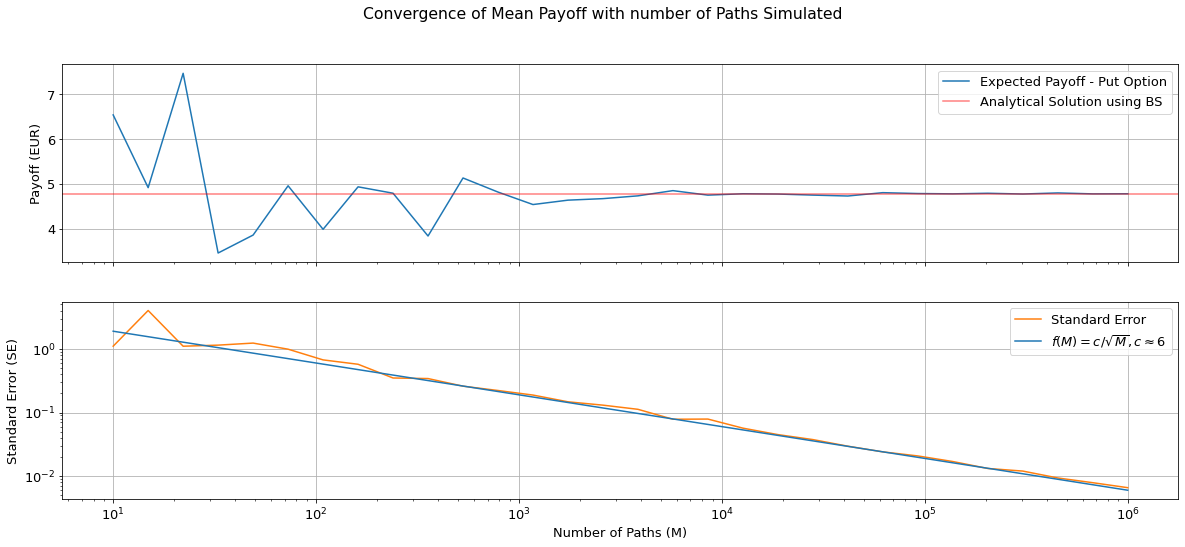

In [9]:
axs = results_convergence_df.plot(figsize=(20,8), grid=True, title='Convergence of Mean Payoff with number of Paths Simulated', subplots=True, logx=True)
axs[0].set_ylabel('Payoff (EUR)')
axs[0].axhline(4.778969051891707, color='r', linestyle='-', alpha=.5, label='Analytical Solution using BS') ;   axs[0].legend()

axs[1].plot(M_values, [ 6/np.sqrt(_m_value)  for _m_value in M_values], label=r'$f(M) = c/\sqrt{M}, c \approx 6$')    ;   axs[1].legend()

axs[1].set_yscale('log')
axs[1].set_ylabel('Standard Error (SE)')

## Different MC Implementation Approaches
> Vanilla MC - 100,000 samples
Mean = 4.757270
Standard Error = 0.025220

> Bootstrapping Results with and without Antithetic (AT) VR - with 100,000 samples and sqrt(samples) df
------ Without AT ------
Mean = 4.7845864899592705
Standard Error = 0.026560446487301444
------ With AT ------
Mean = 4.764542084945663
Standard Error = 0.020000435977867624

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Strike Price Graph

In [9]:
M = 100_000 ;   size_of_graph = 40 ;   start_x = 1  ;   end_x = 200

K_values = np.linspace(start_x, end_x, size_of_graph, dtype=int)

""" Creates a DataFrame to fill with values """
results_k_df = pd.DataFrame(np.zeros((size_of_graph, 3)), index=K_values , columns=['Expected Payoff - Put Option', 'Standard Error (SE)', 'Relative Standard Error (RSE)'])
results_k_df.index.name = 'Strike Price (EUR)'

for K in tqdm(K_values):
    _m, _se = bootstrapping(M, K=K)
    results_k_df.loc[K] = (_m, _se, _se/_m *100.) if _m!= 0 else np.nan

results_k_df

100%|██████████| 40/40 [12:00<00:00, 18.00s/it]


,Expected Payoff - Put Option,Standard Error (SE),Relative Standard Error (RSE)
Strike Price (EUR),,,
1,NaN,NaN,NaN
6,NaN,NaN,NaN
11,NaN,NaN,NaN
16,NaN,NaN,NaN
21,NaN,NaN,NaN
26,NaN,NaN,NaN
31,NaN,NaN,NaN
36,NaN,NaN,NaN
41,NaN,NaN,NaN


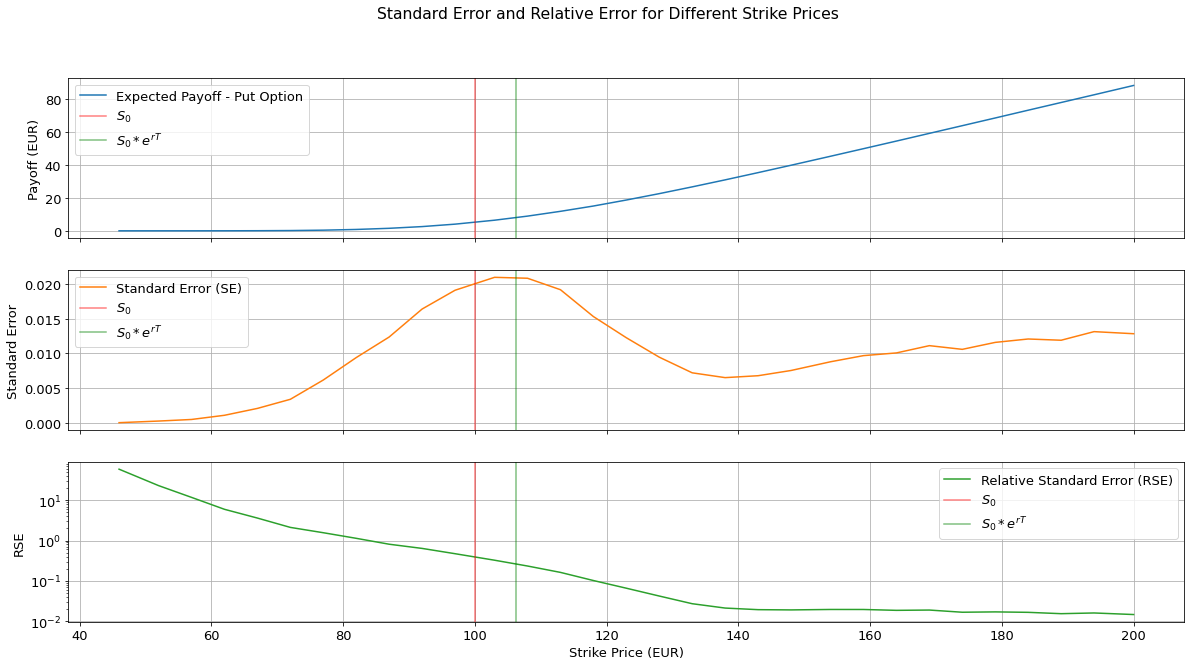

In [10]:
axs = results_k_df.plot(figsize=(20,10), grid=True, title='Standard Error and Relative Error for Different Strike Prices', subplots=True)
axs[0].set_ylabel('Payoff (EUR)')   ;   axs[1].set_ylabel('Standard Error')   ;   axs[2].set_ylabel('RSE')
axs[2].set_yscale('log')

axs[0].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[0].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[0].legend()
axs[1].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[1].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[1].legend()
axs[2].axvline(100, color='r', linestyle='-', alpha=.5, label=r'$S_0$')
axs[2].axvline(100*np.exp(.06), color='g', linestyle='-', alpha=.5, label=r'$S_0*e^{rT}$') ;   axs[2].legend()

plt.legend()

----------------------------------------------------------------------------------------------------------------------------------------------------------------
## Volatility Graph

In [11]:
M = 100_000 ;   size_of_graph = 40 ;   start_v = .01  ;   end_v = 10

V_values = np.logspace(np.log10(start_v), np.log10(end_v), size_of_graph)

""" Creates a DataFrame to fill with values """
results_V_df = pd.DataFrame(np.zeros((size_of_graph, 3)), index=np.log10(V_values) , columns=['Expected Payoff - Put Option', 'Standard Error (SE)', 'Relative Standard Error (RSE)'])
results_V_df.index.name = 'Realized Volatility (σ)'

for V in tqdm(V_values):
    _m, _se = bootstrapping(M, sigma=V)
    results_V_df.loc[np.log10(V)] = (_m, _se, _se/_m *100) #  if _m > 0 else 0

results_V_df

  0%|          | 0/40 [00:00<?, ?it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_42158/3215637781.py:11: RuntimeWarning: invalid value encountered in double_scalars
  results_V_df.loc[np.log10(V)] = (_m, _se, _se/_m *100) #  if _m > 0 else 0
100%|██████████| 40/40 [11:49<00:00, 17.74s/it]


,Expected Payoff - Put Option,Standard Error (SE),Relative Standard Error (RSE)
Realized Volatility (σ),,,
-2.000000,0.000000,0.000000,NaN
-1.923077,0.000000,0.000000,NaN
-1.846154,0.000000,0.000000,NaN
-1.769231,0.000011,0.000007,60.304078
-1.692308,0.000121,0.000032,26.818993
-1.615385,0.001439,0.000130,9.019999
-1.538462,0.006676,0.000317,4.750599
-1.461538,0.026055,0.000708,2.719128
-1.384615,0.073583,0.001347,1.830081


([<matplotlib.axis.XTick at 0x12eda4520>,
 [Text(-2.0, 0, '0.01'),
  Text(-1.5, 0, '0.03'),
  Text(-1.0, 0, '0.10'),
  Text(-0.5, 0, '0.32'),
  Text(0.0, 0, '1.00'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10.00')])

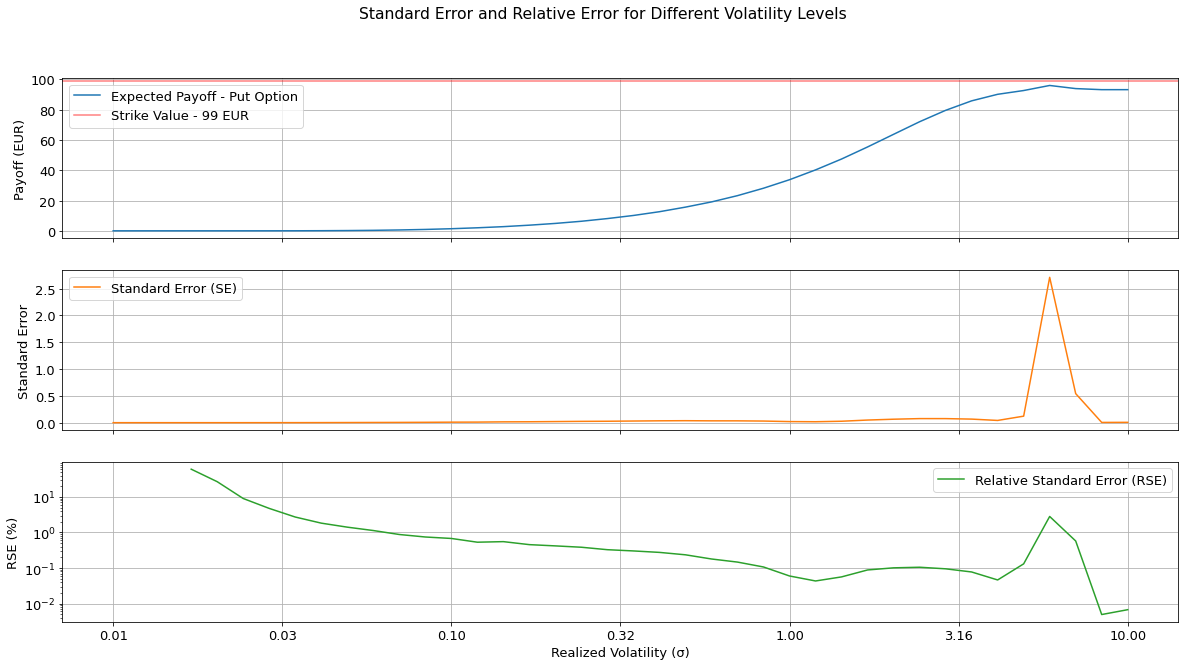

In [12]:
axs = results_V_df.plot(figsize=(20,10), grid=True, title='Standard Error and Relative Error for Different Volatility Levels', subplots=True) #, xticks=V_values)
axs[0].set_ylabel('Payoff (EUR)')   ;   axs[1].set_ylabel('Standard Error')   ;   axs[2].set_ylabel('RSE (%)')
axs[2].set_yscale('log')
axs[0].axhline(99, color='r', linestyle='-', alpha=.5, label='Strike Value - 99 EUR') ;   axs[0].legend()

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x:.2f}' for x in plt.xticks()[0][1:-1]])

## 3D Plot - Strike Price / Volatility

In [101]:
import multiprocessing
from joblib import Parallel, delayed

""" Simulation Parameters """
M = 10_000    ;    total_points = 900  ;    print(f'Total Paths Calculated (M) = {M*total_points}')# points should be [2500, 900]

start_sigma = 0.01  ;   end_sigma = 20
start_K = 1  ;   end_K = 200

""" Prepare Input """
size_of_graph = np.sqrt(total_points).astype(int)   # points should be [2500, 900]
V_values = np.logspace(np.log10(start_sigma), np.log10(end_sigma), size_of_graph, base=10)
# V_values = np.linspace(start_sigma, end_sigma, size_of_graph)
K_values = np.linspace(start_K, end_K, size_of_graph, dtype=int)

input_matrix = np.empty((0, 2))
for sigma in V_values:
    for K in K_values:
        input_matrix = np.append(input_matrix, np.array([[sigma, K]]), axis=0)

inputs = tqdm(input_matrix)


""" Define function that calculates """
def simulate(input_matrix):
    """ X """
    # x = np.log10(input_matrix[0])
    """ Y """
    # y = input_matrix[1]
    """ Z """
    _m, _se = bootstrapping(M, sigma=input_matrix[0], K=input_matrix[1])
    _r = (_se  /_m *100) if _m!= 0 else 0
    return np.array([np.log10(input_matrix[0]), input_matrix[1], _r])


""" Run Parallel Simulation """
num_cores = multiprocessing.cpu_count()
temp_output = Parallel(n_jobs=num_cores)(delayed(simulate)(row) for row in inputs)
""" Revert back to matrix form"""
# print(temp_output)
result_3D = np.empty((0, 3))
for array in temp_output:
    result_3D = np.append(result_3D, [array], axis=0)

Total Paths Calculated (M) = 9000000


100%|██████████| 900/900 [06:57<00:00,  2.15it/s]


/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/3597477947.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], np.log10(result_3D[:, 2]), cmap=cm.jet, linewidth=0.2)


Text(0.5, 0.92, 'RSE for Different Strike Price and Volatility Levels')

/Users/alexanderithakis/miniforge3/envs/QF/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


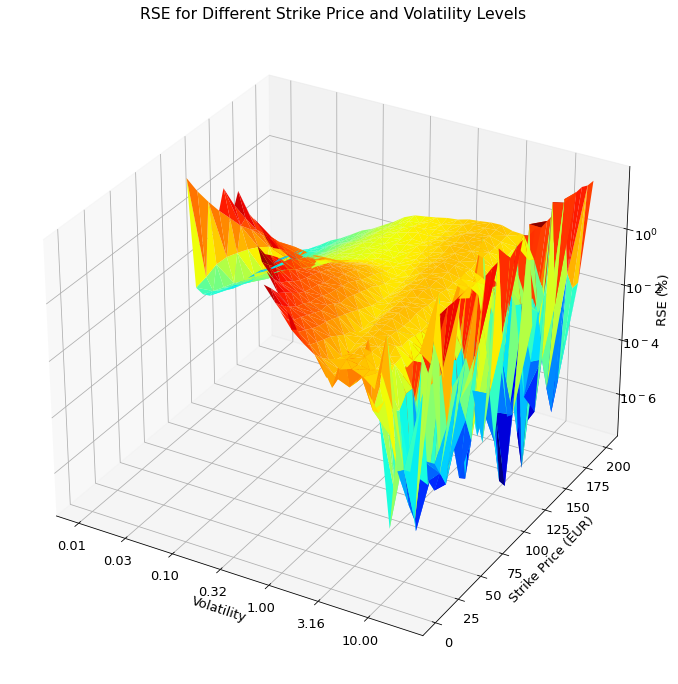

In [102]:
import matplotlib.ticker as mticker
from matplotlib import cm
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection='3d')
ax.plot_trisurf(result_3D[:, 0], result_3D[:, 1], np.log10(result_3D[:, 2]), cmap=cm.jet, linewidth=0.2)

def log_tick_formatter(val, pos=None):
    return r"$10^{:.0f}$".format(val)

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

plt.xticks(plt.xticks()[0][1:-1], [f'{10**x:.2f}' for x in plt.xticks()[0][1:-1]])

ax.set_ylabel('Strike Price (EUR)')   ;   ax.set_xlabel('Volatility')   ;   ax.set_zlabel('RSE (%)')
ax.set_title("RSE for Different Strike Price and Volatility Levels")

__________________________________________________________________________________________________________________________________________________________________________
# Part 2
## Question 1

In [85]:
""" Bootstrapping Technique """
def option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    epsilon = 0.001

    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        for _inx in range(M):
            _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
    if calc_delta:
        _results_2 = - np.ones((M, bootstrap_trials))
        for b_trial in range(bootstrap_trials):
            for _inx in range(M):
                _results_2[_inx, b_trial] = max(K- _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
        delta =
        return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1]), delta / epsilon

    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])


In [130]:
M_values = 10**np.array([2, 3, 4, 5])
S0 = 100
epsilon= 0.1

""" Random Seed """
results_no_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_no_seed = np.append(results_no_seed, np.array([option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None)]), axis=0)
results_no_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_no_seed), axis=1)

""" Fixed Seed """
results_with_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_with_seed = np.append(results_with_seed, np.array([option_evaluation_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=21)]), axis=0)
results_with_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_with_seed), axis=1)

100%|██████████| 4/4 [00:46<00:00, 11.55s/it]


In [131]:
""" Analytical Results
Option Value with Black-Scholes Formula = 4.778969051891707
Delta Value with Black-Scholes Formula = -0.3262644882651039
"""
V_analytical = 4.778969051891707    ;   D_Analytical = -0.3262644882651039

results_no_seed_df = pd.DataFrame(results_no_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_no_seed_df.insert(1, "Difference in Payoff with BS", results_no_seed_df[['E[Payoff of Put Option]']].to_numpy()- V_analytical)
results_no_seed_df.insert(4, "Difference in Delta with BS", results_no_seed_df[['Delta']].to_numpy()- D_Analytical)
results_no_seed_df

,E[Payoff of Put Option],Difference in Payoff with BS,Standard Error,Delta,Difference in Delta with BS
M,,,,,
100.0,5.524627,0.745658,0.281233,469.945073,470.271338
1000.0,4.683002,-0.095967,0.226101,84.355683,84.681947
10000.0,4.739412,-0.039557,0.056204,9.711023,10.037287
100000.0,4.807209,0.028240,0.020689,-17.331446,-17.005182


In [132]:
results_with_seed = pd.DataFrame(results_with_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_with_seed.insert(1, "Difference in Payoff with BS", results_with_seed[['E[Payoff of Put Option]']].to_numpy()- V_analytical)
results_with_seed.insert(4, "Difference in Delta with BS", results_with_seed[['Delta']].to_numpy()- D_Analytical)
results_with_seed

,E[Payoff of Put Option],Difference in Payoff with BS,Standard Error,Delta,Difference in Delta with BS
M,,,,,
100.0,3.735218,-1.043751,0.489956,-0.335587,-0.009322
1000.0,4.479403,-0.299566,0.196551,-0.320965,0.005299
10000.0,4.848506,0.069537,0.058999,-0.327064,-0.000800
100000.0,4.808095,0.029126,0.020162,-0.325553,0.000712


________________________________________________________________________________________________________________________________________________________________________
## Question 2 - Digital Option

In [204]:
def digital_option_MC(M, K = 99, sigma = 0.2, calc_delta=True, seed=None):
    def _gbm_euler(S0, r, sigma, T, M, zm):
        dt = T / M
        Sm = np.zeros((M+1, 2), dtype=float)   ;   Sm[0, 0] = S0
        for m in range(1, M+1):
            Sm[m, 0] = Sm[m-1, 0] + r*Sm[m-1, 0]*dt + sigma*Sm[m-1, 0]*sqrt(dt)*zm[m-1]
            Sm[m, 1] = m * dt
        return Sm[-1,0]

    epsilon = 0.001

    r = 0.06
    T = 1.
    N = 254

    # K = 99

    M = np.sqrt(M).astype(int)   ;   bootstrap_trials = M

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """

    _results = - np.ones((M, bootstrap_trials))
    for b_trial in range(bootstrap_trials):
        for _inx in range(M):
            # _results[_inx, b_trial] = max(K- _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
            # _results[_inx, b_trial] = 1 if _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) > K else 0
            x = _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) - K
            _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))

    """ Create the Random Variables """
    np.random.seed(seed=seed)
    zm = np.random.normal(loc=0., scale=1, size=(N, ceil(M/2), bootstrap_trials))
    zm = np.concatenate((zm, -zm[:,:floor(M/2)]), axis=1)  ;  """ Antithetic Variable """
    if calc_delta:
        _results_2 = - np.ones((M, bootstrap_trials))
        for b_trial in range(bootstrap_trials):
            for _inx in range(M):
                # _results_2[_inx, b_trial] = max(K- _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]), 0) * np.exp(-r*T)
                # _results_2[_inx, b_trial] = 1*np.exp(-r*T) if _gbm_euler(S0, r, sigma, T, N, zm[:, _inx, b_trial]) > K else 0
                x = _gbm_euler(S0+epsilon, r, sigma, T, N, zm[:, _inx, b_trial]) - K
                _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
        delta = np.mean(_results_2, axis=0).mean() - np.mean(_results, axis=0).mean()
        return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1]), delta / epsilon

    return np.mean(_results, axis=0).mean(), np.mean(_results, axis=0).std() / np.sqrt(_results.shape[1])

In [205]:
M_values = 10**np.array([2, 3, 4])

""" Random Seed """
results_no_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_no_seed = np.append(results_no_seed, np.array([digital_option_MC(M, K = 99, sigma = 2, calc_delta=True, seed=None)]), axis=0)
results_no_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_no_seed), axis=1)

""" Fixed Seed """
results_with_seed = np.empty((0,3))
for M in tqdm(M_values):
    results_with_seed = np.append(results_with_seed, np.array([digital_option_MC(M, K = 99, sigma = 2, calc_delta=True, seed=21)]), axis=0)
results_with_seed = np.concatenate((M_values.reshape(M_values.shape[0], 1), results_with_seed), axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/857941237.py:31: RuntimeWarning: overflow encountered in exp
  _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_43792/857941237.py:44: RuntimeWarning: overflow encountered in exp
  _results[_inx, b_trial] = 1 / (1 + np.exp(-100*x))
100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


In [206]:
results_no_seed_df = pd.DataFrame(results_no_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_no_seed_df

,E[Payoff of Put Option],Standard Error,Delta
M,,,
100.0,0.150000,0.032404,-1150.000000
1000.0,0.171959,0.008992,-1171.958763
10000.0,0.164200,0.003037,-1164.200388


In [207]:
results_with_seed_df = pd.DataFrame(results_with_seed, columns=['M', 'E[Payoff of Put Option]', 'Standard Error', 'Delta']).set_index('M')
results_with_seed_df

,E[Payoff of Put Option],Standard Error,Delta
M,,,
100.0,0.080000,0.027568,-1080.000000
1000.0,0.147763,0.008164,-1147.762986
10000.0,0.168100,0.003411,-1168.100350


# Part 3: Asian Options and Control Variets

In [307]:
""" Euler's Method """
def gbm_euler(S0, r, sigma, T, N):
    zm = norm.rvs(loc=0., scale=1, size=N)
    dt = T / N
    Sm = np.zeros(N+1, dtype=float)   ;   Sm[0] = S0
    for m in range(1, N+1):
        Sm[m] = Sm[m-1] + r*Sm[m-1]*dt + sigma*Sm[m-1]*sqrt(dt)*zm[m-1]
    return Sm

In [308]:
def geometric_analytical(S0, r, sigma, T, N, M, K):
    # Define the sigma bar and r bar
    sigma_bar = sigma * sqrt((2 * N + 1)/(6 * (N + 1)))
    r_bar = 0.5 * (r - 0.5 * sigma **2 + sigma_bar **2)

    # Define d1 and d2
    d1 = (log(S0/K) + (r_bar + 1/2 * sigma_bar ** 2) * T)/(sigma_bar * sqrt(T))
    d2 = d1 - (sigma_bar * sqrt(T))

    # Find the analytical expression
    analytical_value = exp(-r * T) * (S0 * exp(r_bar * T) * norm.cdf(d1) - K * norm.cdf(d2))

    return analytical_value

In [309]:
# Arithmetic Monte Carlo
def MC(S0, r, sigma, T, N, M, K):
    mc_values_arit = np.zeros(M)
    mc_values_geo = np.zeros(M)
    for m in range(M):
        Sm = gbm_euler(S0, r, sigma, T, N)
        
        # Get arithmetic average
        AN = Sm.mean()
        
        mc_values_arit[m] = max(0, AN - K) * exp(-r * T)
        
        # Get geometric average
        AN = gmean(Sm)
        
        mc_values_geo[m] = max(0, AN - K) * exp(-r * T)

    return mc_values_arit, mc_values_geo

In [310]:
def control_variate_est(S0, r, sigma, T, N, M, K):
    analytical_value = geometric_analytical(S0, r, sigma, T, N, M, K)
    mc_values_arit, mc_values_geo = MC(S0, r, sigma, T, N, M, K)
    
    A_arit = mc_values_arit.mean()
    A_arit_sd = mc_values_arit.std()
    A_geo = mc_values_geo.mean()
    A_geo_sd = mc_values_geo.std()

    # Control variate estimate Asian option
    rho, _ = pearsonr(mc_values_geo, mc_values_arit)
    
    if A_geo_sd == 0:
        beta = 0
    else:
        beta = (A_arit_sd / A_geo_sd) * rho

    estimate = A_arit - beta * (A_geo - analytical_value)

    return estimate, A_arit

In [316]:
# Input parameter values
S0 = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2
M = 100_000

analytical_geo_value = geometric_analytical(S0, r, sigma, T, N, M, K)
_, MC_geo_value_high = MC(S0, r, sigma, T, N, M, K)

M = 1_000
_, MC_geo_value_low = MC(S0, r, sigma, T, N, M, K)

analytical_geo_value = analytical_geo_value.mean()
MC_geo_value_high = MC_geo_value_high.mean()
MC_geo_value_low = MC_geo_value_low.mean()

print("Analytical estimate:", analytical_geo_value)
print("MC estimate high M:", MC_geo_value_high)
print("MC estimate low M:", MC_geo_value_low)
print("Difference of analytical and MC estimate high (in %):", (MC_geo_value_high - analytical_geo_value)/analytical_geo_value)
print("Difference of analytical and MC estimate low (in %):", (MC_geo_value_low - analytical_geo_value)/analytical_geo_value)

Analytical estimate: 6.310747867416329
MC estimate high M: 6.348171820538498
MC estimate low M: 5.887265630542011
Difference of analytical and MC estimate high (in %): 0.005930193046595417
Difference of analytical and MC estimate low (in %): -0.06710492096520651


In [313]:
control_var_est, MC_arit_est = control_variate_est(S0, r, sigma, T, N, M, K)

print("Control Variate estimate:", control_var_est)
print("MC arithmetic estimate:", MC_arit_est)
print("Difference of control variate and arithmetic MC estimates (in %):", (control_var_est - MC_arit_est)/MC_arit_est)

Control Variate estimate: 6.547796367646076
MC arithmetic estimate: 6.5782415741695415
Difference of control variate and arithmetic MC estimates (in %): -0.004628167904780659


## Changing M

In [279]:
S0 = 100
T = 1.
N = 50
K = 99
r = 0.06
sigma = 0.2

num_samples = 100
M_values = np.logspace(start=1, stop=6, num=num_samples, base=10, dtype=int)
print(M_values)

M_estimates_c = np.zeros(num_samples)
M_estimates_MC = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    M = M_values[i]
    M_estimates_c[i], M_estimates_MC[i] = control_variate_est(S0, r, sigma, T, N, M, K)

[     10      11      12      14      15      17      20      22      25
      28      31      35      40      45      50      57      64      72
      81      91     102     114     129     145     162     183     205
     231     259     291     327     367     413     464     521     585
     657     739     830     932    1047    1176    1321    1484    1668
    1873    2104    2364    2656    2983    3351    3764    4229    4750
    5336    5994    6734    7564    8497    9545   10722   12045   13530
   15199   17073   19179   21544   24201   27185   30538   34304   38535
   43287   48626   54622   61359   68926   77426   86974   97700  109749
  123284  138488  155567  174752  196304  220513  247707  278255  312571
  351119  394420  443062  497702  559081  628029  705480  792482  890215
 1000000]


100%|█████████████████████████████████████████| 100/100 [18:21<00:00, 11.02s/it]


In [280]:
print(M_estimates_c)
print(M_estimates_MC)

[6.47930496 6.52211024 6.50858215 6.49733382 6.50564307 6.61043086
 6.52433088 6.49106215 6.61592724 6.58373981 6.50784812 6.50576561
 6.62364226 6.5828815  6.52035723 6.57356653 6.57005662 6.55287226
 6.58042648 6.56825547 6.52923843 6.58434724 6.518678   6.5678047
 6.5868009  6.56302203 6.52166314 6.54227714 6.54912264 6.53021801
 6.54875384 6.53361125 6.54949098 6.56382868 6.53342144 6.54971723
 6.53868152 6.54509976 6.54353455 6.54358314 6.54962858 6.54867318
 6.55001054 6.54637652 6.55294642 6.54772023 6.54897165 6.54597433
 6.54572405 6.55369337 6.54773281 6.54506916 6.54375583 6.54294255
 6.54538082 6.55100185 6.54535186 6.54492202 6.54818575 6.55072889
 6.54818976 6.5497482  6.54627471 6.54549416 6.55122884 6.54346832
 6.5474234  6.54590223 6.54751515 6.54873719 6.54643386 6.54792942
 6.54740539 6.54888334 6.54881698 6.54688036 6.54656451 6.54567152
 6.54688925 6.54827551 6.54735677 6.54785076 6.54712392 6.5485059
 6.54749949 6.54786764 6.54757437 6.5476231  6.54783474 6.547899

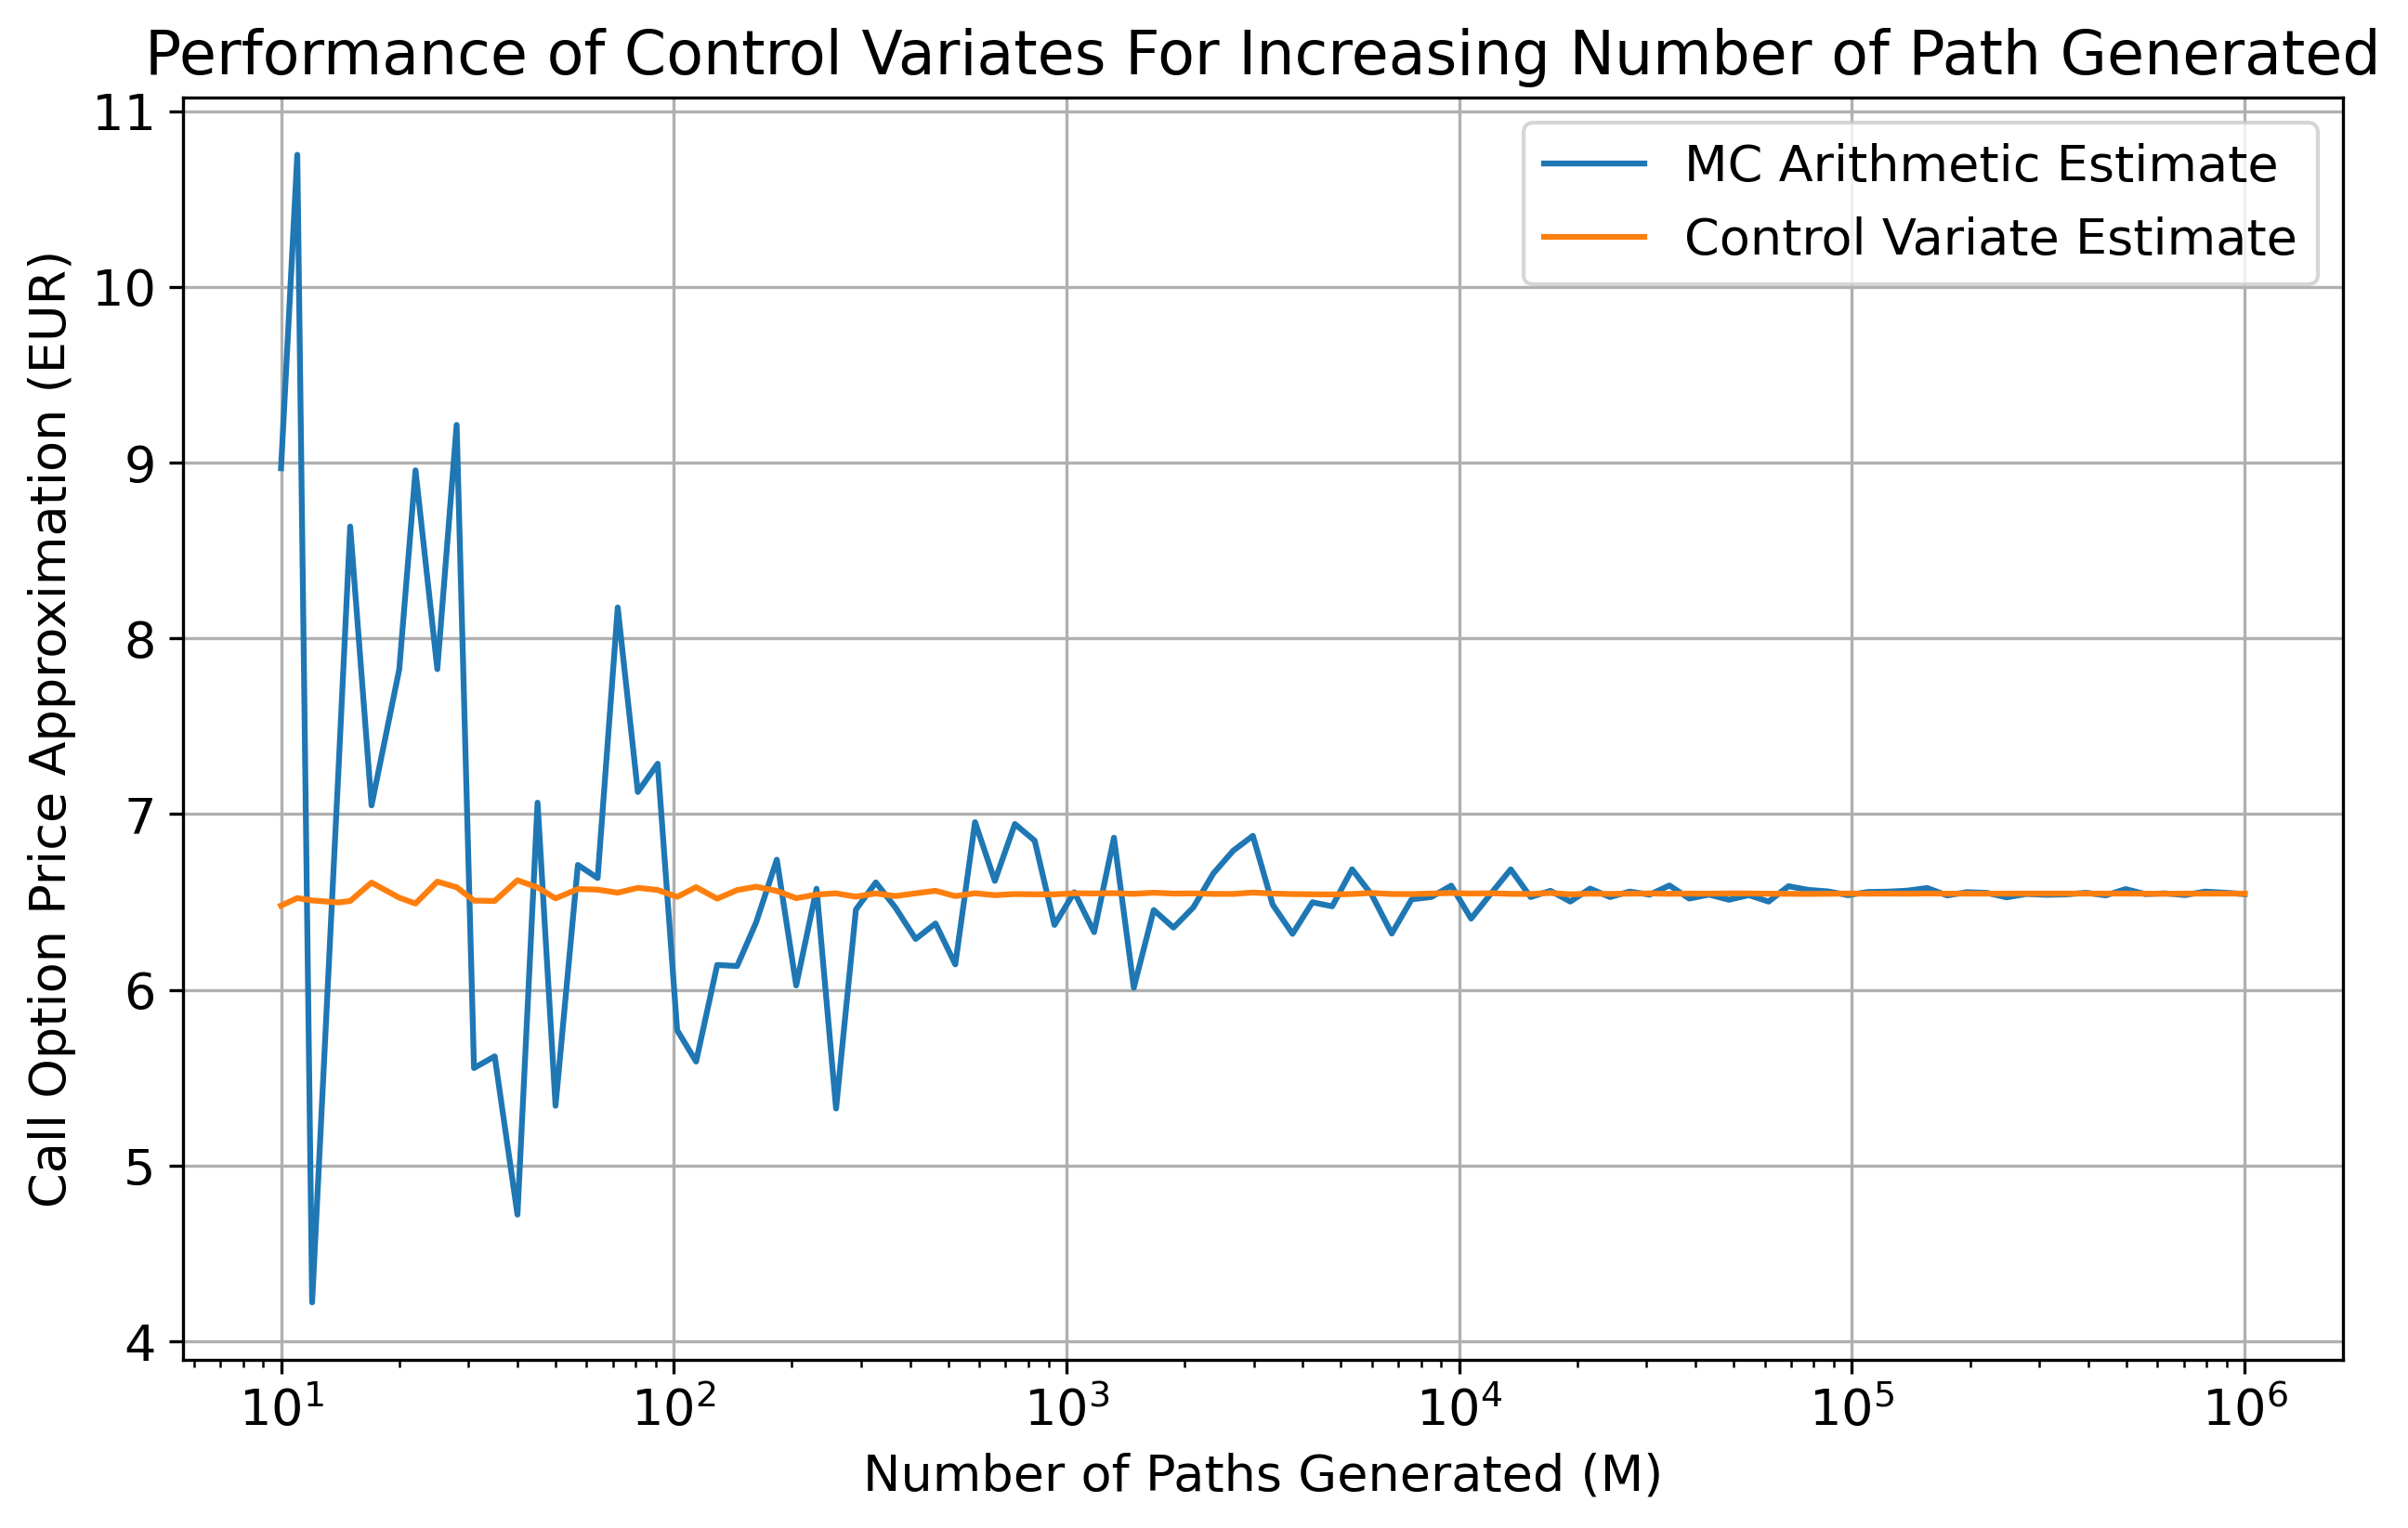

In [281]:
plt.figure(figsize=(10,6), dpi=300)
plt.plot(M_values, M_estimates_MC, label='MC Arithmetic Estimate')
plt.plot(M_values, M_estimates_c, label='Control Variate Estimate')
plt.xscale('log',base=10) 
plt.xlabel("Number of Paths Generated (M)")
plt.ylabel("Call Option Price Approximation (EUR)")
plt.title("Performance of Control Variates For Increasing Number of Path Generated")
plt.legend()
plt.grid()
plt.show()

## Changing K

In [268]:
S0 = 100
T = 1.
N = 50
r = 0.06
sigma = 0.2
M = 1_000
trials = 50

num_samples = 100
K_values = np.linspace(1, 200, num=num_samples, dtype=int)
print(K_values)

K_estimates_c = np.zeros(num_samples)  ; K_estimates_c_se = np.zeros(num_samples)
K_estimates_MC = np.zeros(num_samples) ; K_estimates_MC_se = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    K = K_values[i]
    estimate_c = np.zeros(trials)
    estimate_MC = np.zeros(trials)
    for n in range(trials):
        estimate_c[n], estimate_MC[n] = control_variate_est(S0, r, sigma, T, N, M, K)
    K_estimates_c[i] = estimate_c.mean()
    K_estimates_MC[i] = estimate_MC.mean()
    K_estimates_c_se[i] = estimate_c.std() / sqrt(n)
    K_estimates_MC_se[i] = estimate_MC.std() / sqrt(n)

[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 200]


 68%|████████████████████████████▌             | 68/100 [06:59<03:15,  6.12s/it]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|█████████████████████████████████████████| 100/100 [10:22<00:00,  6.23s/it]


In [344]:
diff = np.zeros(len(K_estimates_c))
for i in range(len(K_estimates_c)):
    if K_values[i] <= 125:
        diff[i] = (np.abs(K_estimates_c[i] - K_estimates_MC[i]) / K_estimates_c[i]) * 100
    print(diff)
    
print(max(diff))

[0.05044412 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.0504441

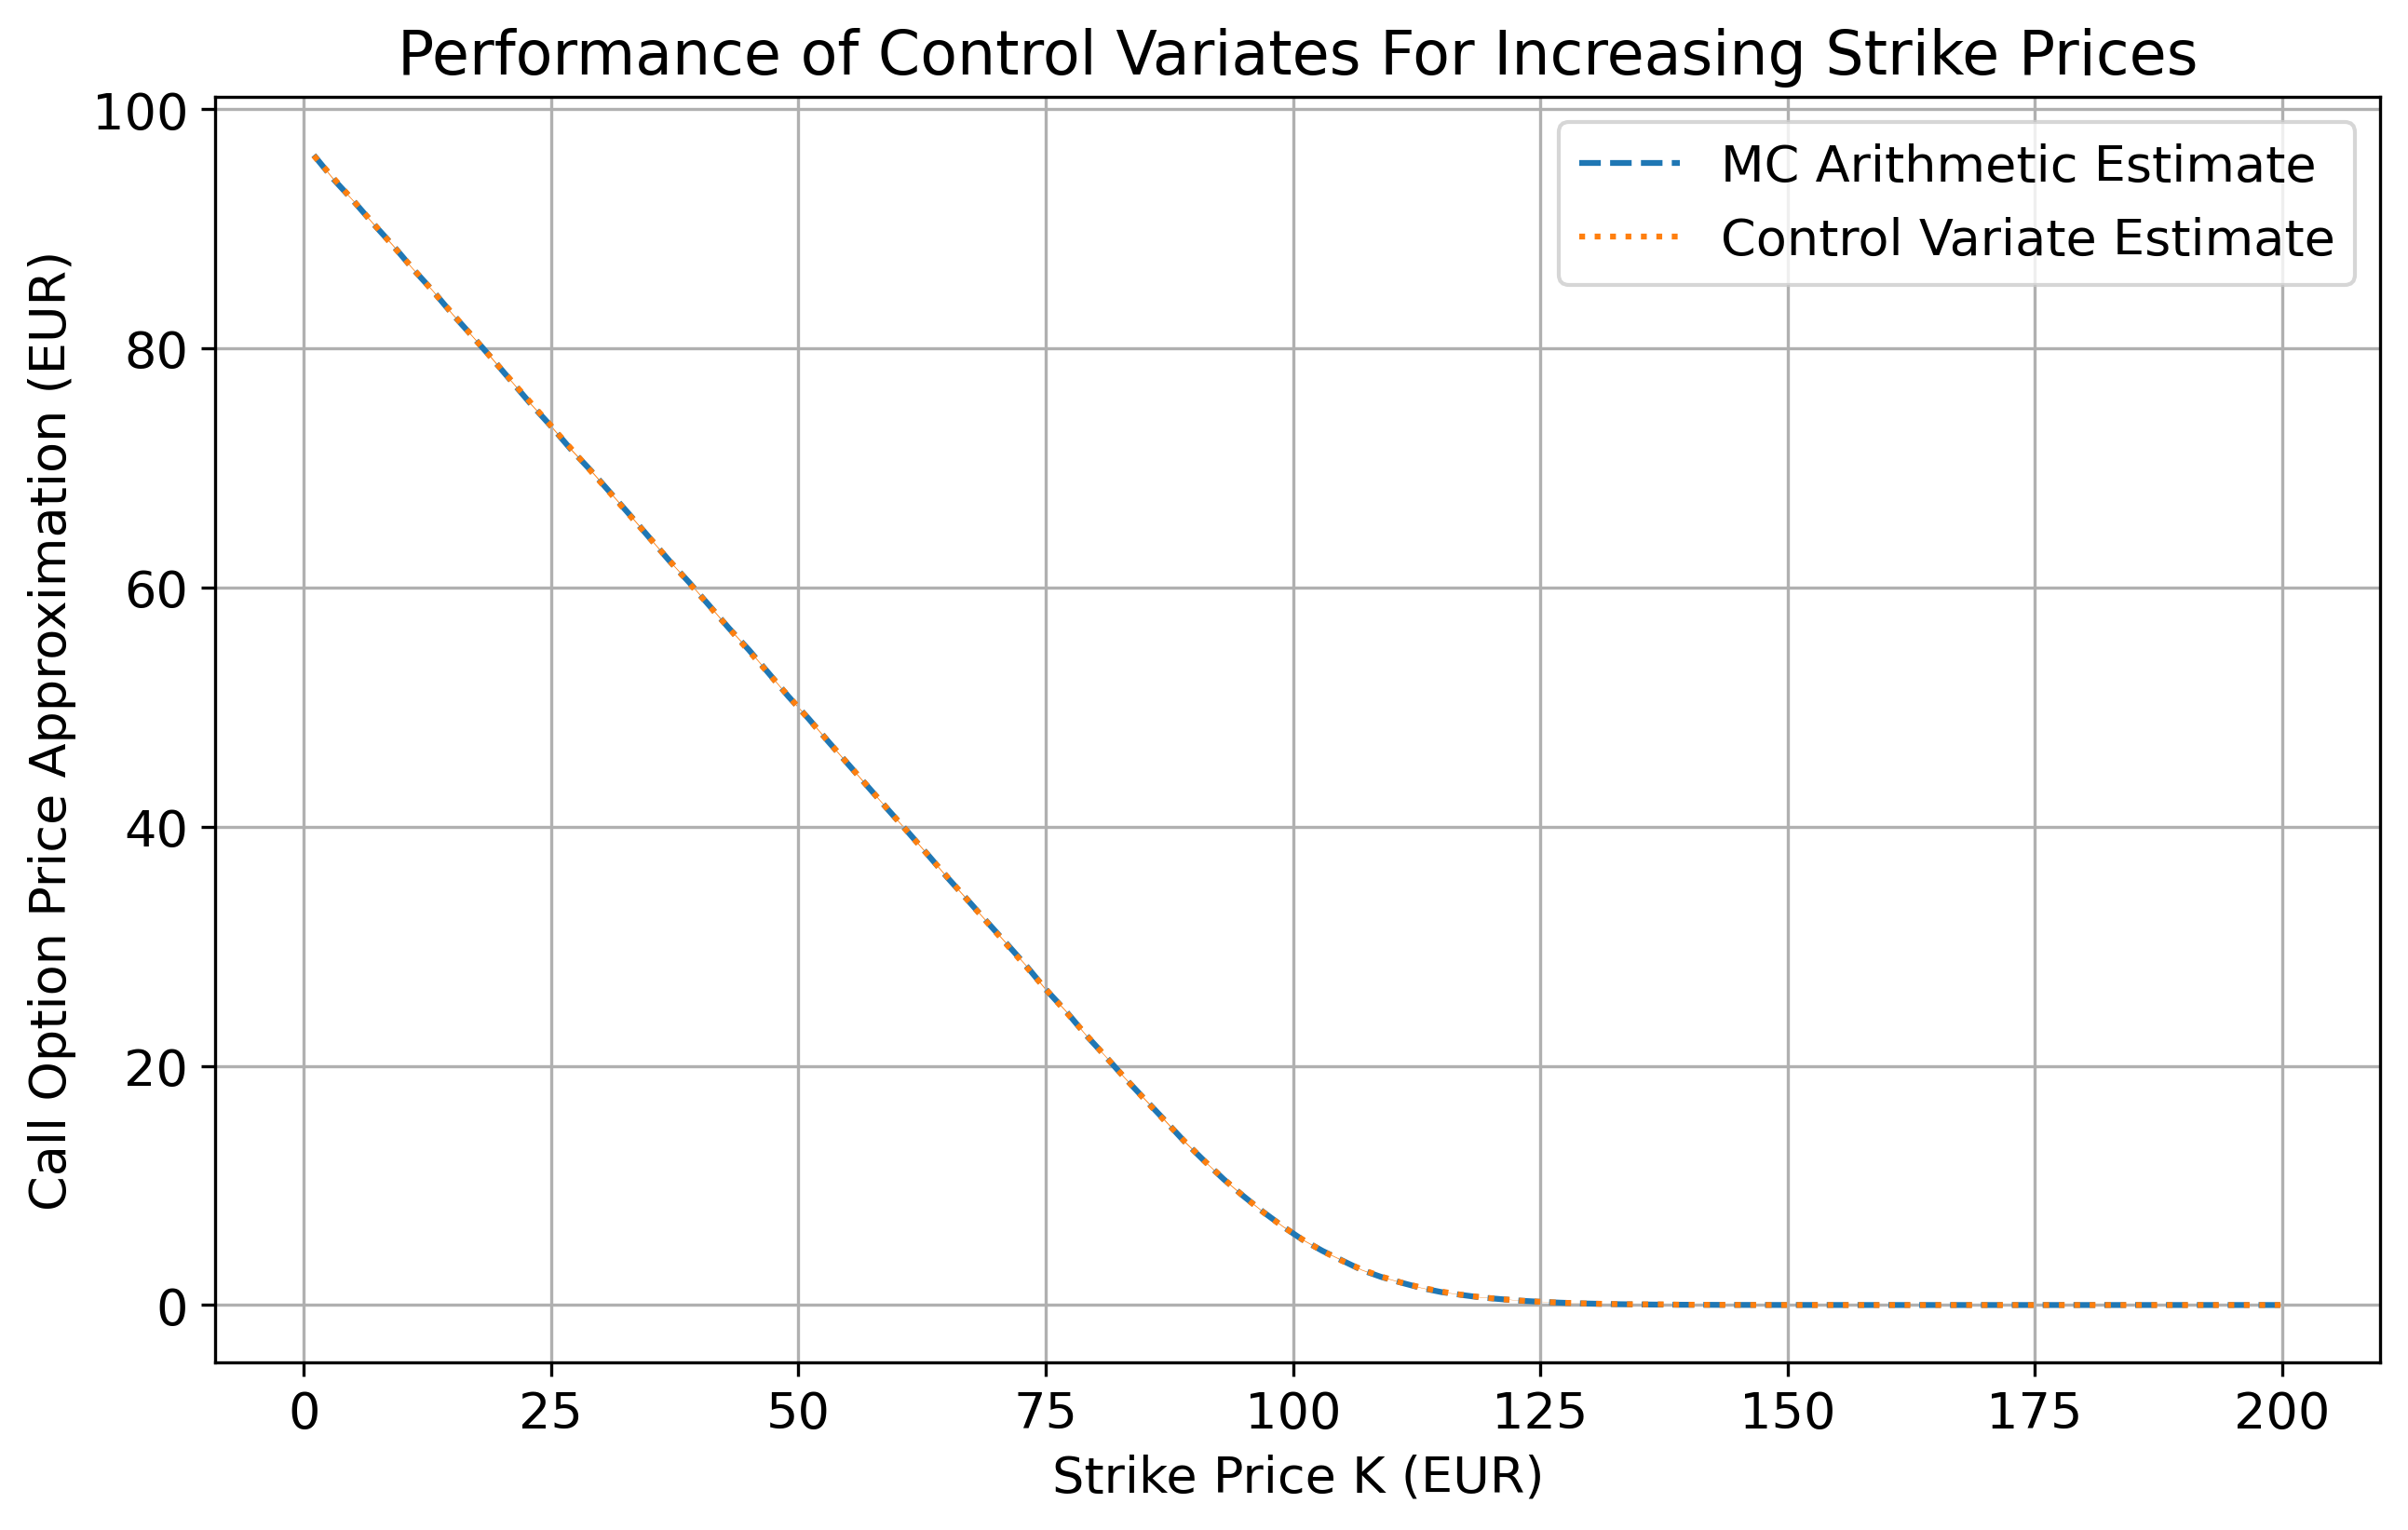

number of trials: 50 
number of paths per trial: 1000000


In [286]:
K_estimates_c_sd = np.zeros(100)
K_estimates_MC_sd = np.zeros(100)
for i in range(len(K_estimates_c_se)):
    K_estimates_c_sd[i] = K_estimates_c_se[i] * sqrt(50)
    K_estimates_MC_sd[i] = K_estimates_MC_se[i] * sqrt(50)

plt.figure(figsize=(10,6), dpi=300)
plt.plot(K_values, K_estimates_MC, label='MC Arithmetic Estimate', linestyle='dashed')
plt.plot(K_values, K_estimates_c, label='Control Variate Estimate', linestyle='dotted')
plt.fill_between(K_values, K_estimates_c - K_estimates_c_se, K_estimates_c + K_estimates_c_se)
plt.fill_between(K_values, K_estimates_MC - K_estimates_MC_se, K_estimates_MC + K_estimates_MC_se)
plt.xlabel("Strike Price K (EUR)")
plt.ylabel("Call Option Price Approximation (EUR)")
plt.title("Performance of Control Variates For Increasing Strike Prices")
plt.legend()
plt.grid()
plt.show()
print("number of trials:", trials, "\nnumber of paths per trial:", M)

## Changing N (number of intervals) 

In [288]:
S0 = 100
T = 1.
K = 99
r = 0.06
sigma = 0.2
M = 1_000
trials = 50

num_samples = 100
N_values = np.linspace(1, 1000, num=num_samples, dtype=int)
print(N_values)

N_estimates_c = np.zeros(num_samples)  ; N_estimates_c_se = np.zeros(num_samples)
N_estimates_MC = np.zeros(num_samples) ; N_estimates_MC_se = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    N = N_values[i]
    estimate_c = np.zeros(trials)
    estimate_MC = np.zeros(trials)
    for n in range(trials):
        estimate_c[n], estimate_MC[n] = control_variate_est(S0, r, sigma, T, N, M, K)
    N_estimates_c[i] = estimate_c.mean()
    N_estimates_MC[i] = estimate_MC.mean()
    N_estimates_c_se[i] = estimate_c.std() / sqrt(n)
    N_estimates_MC_se[i] = estimate_MC.std() / sqrt(n)

[   1   11   21   31   41   51   61   71   81   91  101  112  122  132
  142  152  162  172  182  192  202  212  223  233  243  253  263  273
  283  293  303  313  323  334  344  354  364  374  384  394  404  414
  424  434  445  455  465  475  485  495  505  515  525  535  545  556
  566  576  586  596  606  616  626  636  646  656  667  677  687  697
  707  717  727  737  747  757  767  778  788  798  808  818  828  838
  848  858  868  878  889  899  909  919  929  939  949  959  969  979
  989 1000]


100%|█████████████████████████████████████████| 100/100 [46:35<00:00, 27.96s/it]


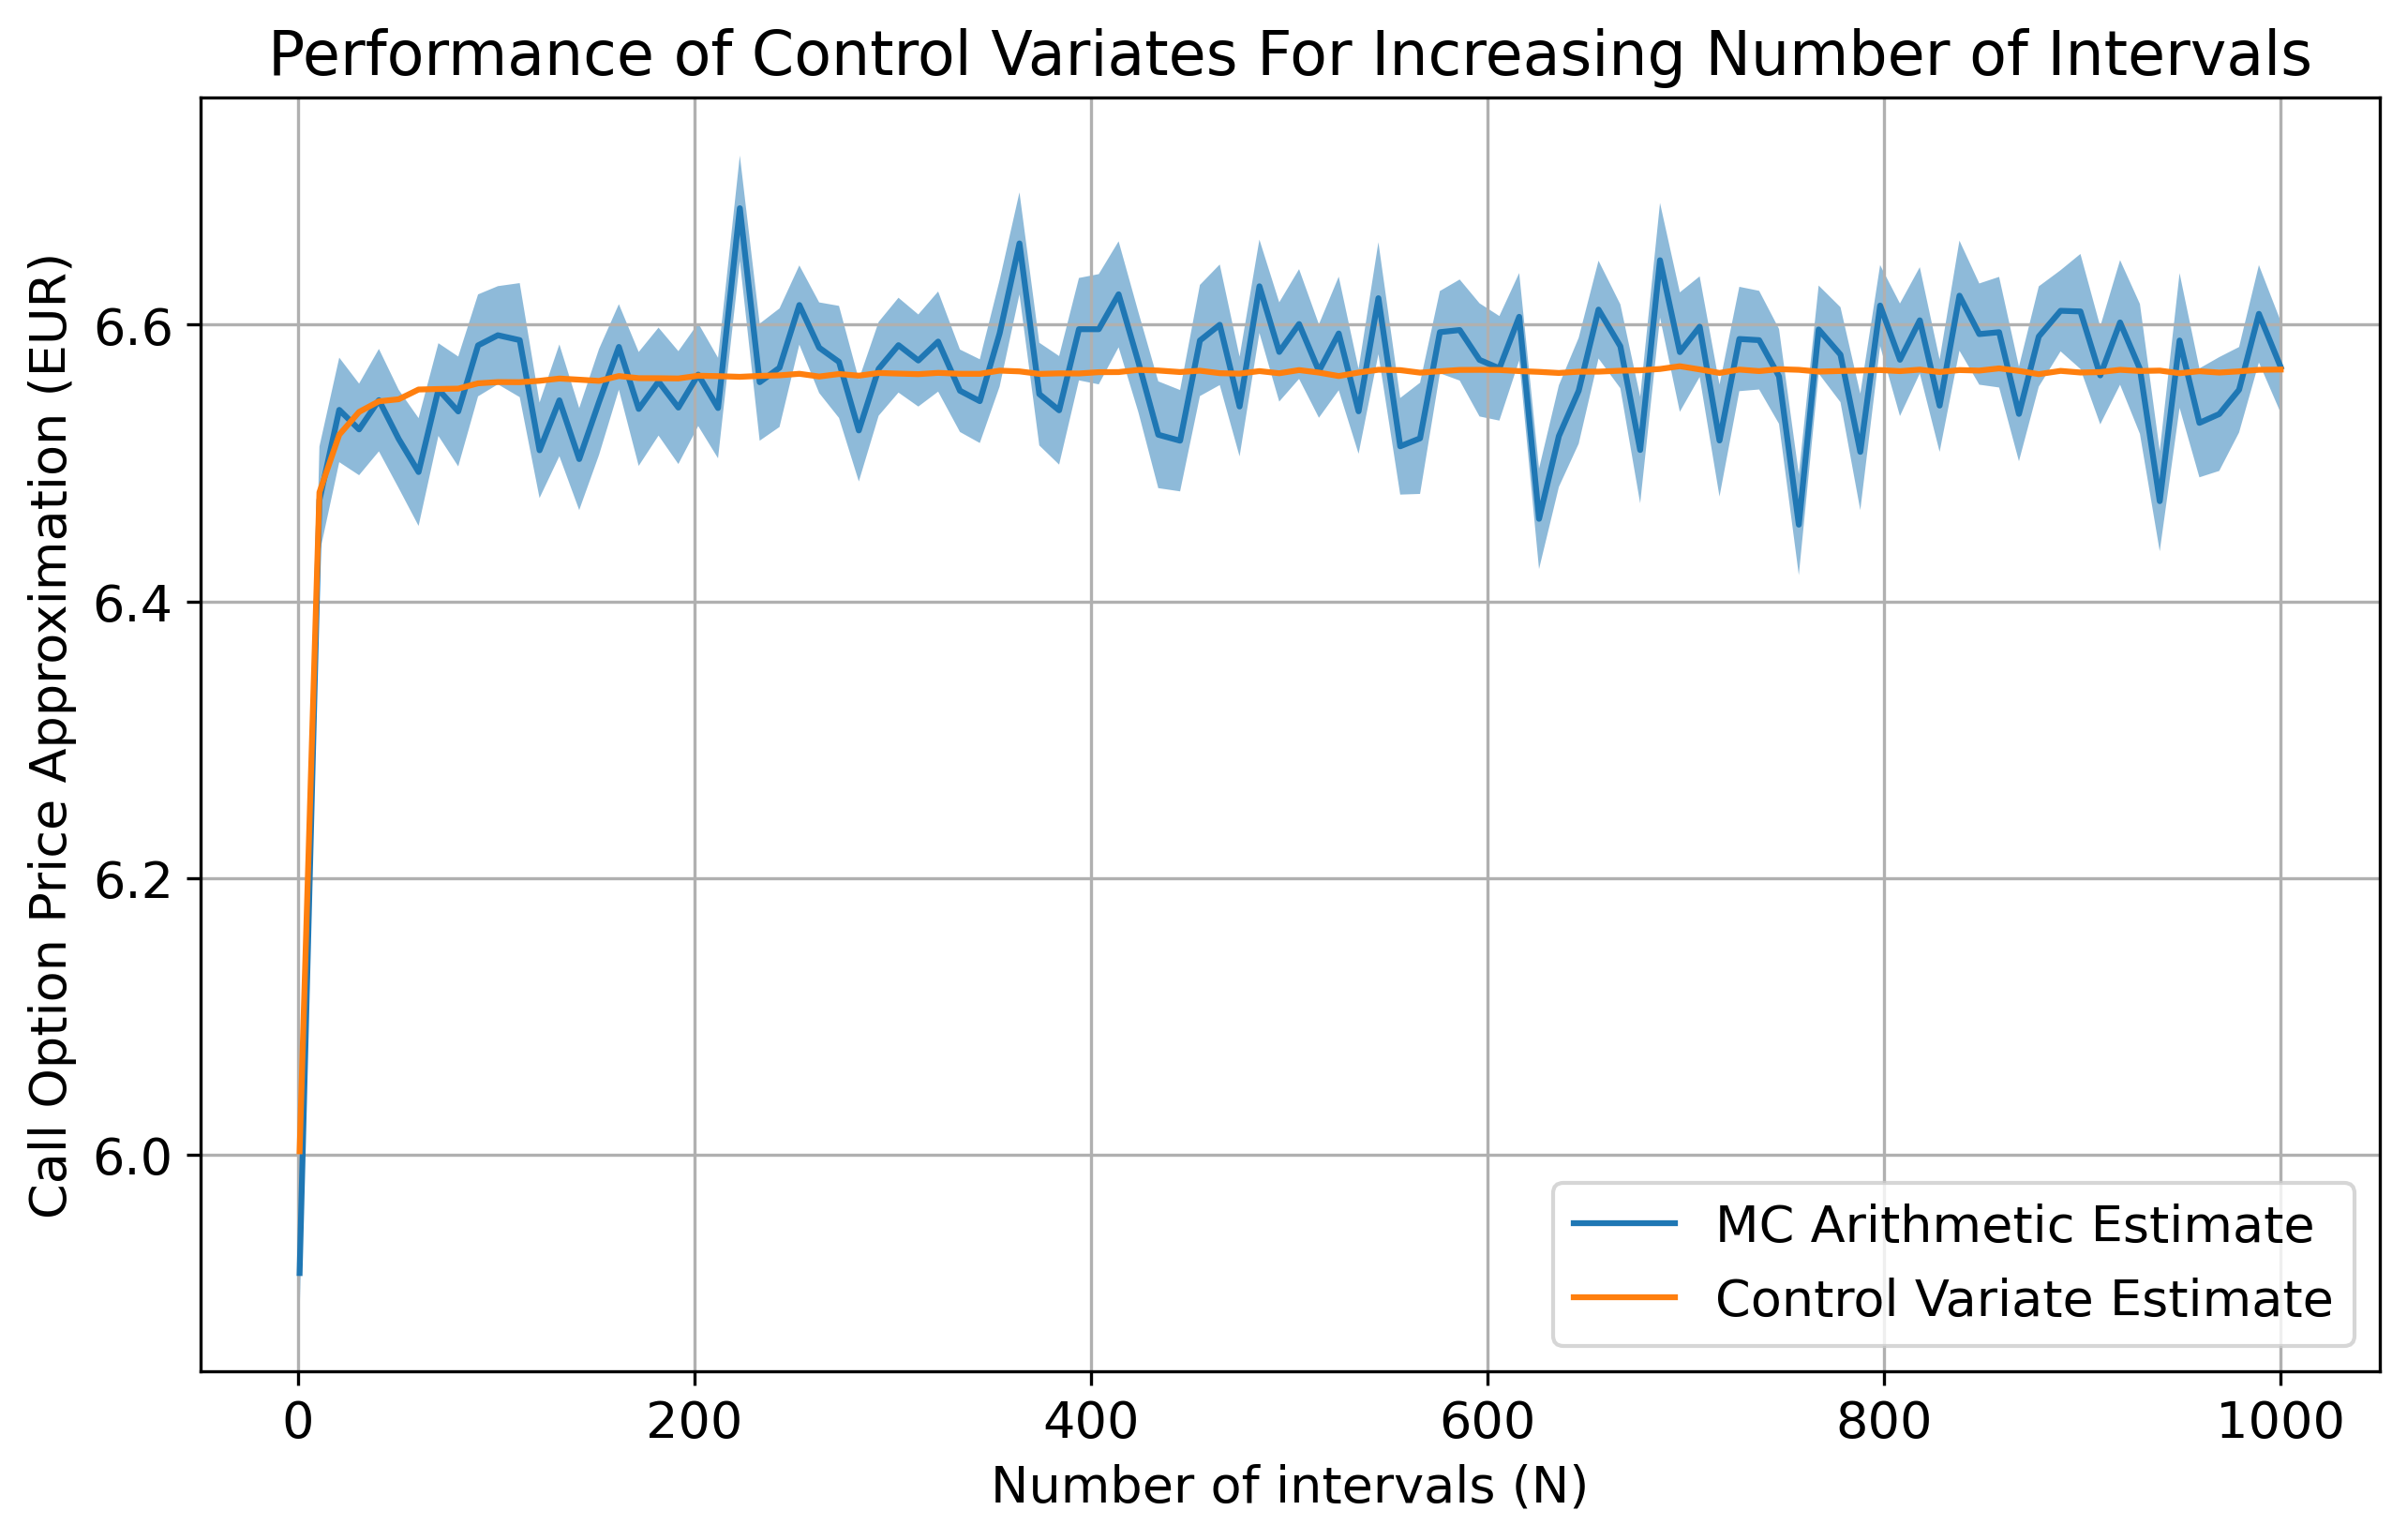

In [305]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
ax.plot(N_values, N_estimates_MC, label='MC Arithmetic Estimate')
ax.plot(N_values, N_estimates_c, label='Control Variate Estimate')
ax.fill_between(N_values, N_estimates_MC - N_estimates_MC_se, N_estimates_MC + N_estimates_MC_se, alpha = 0.5)
ax.fill_between(N_values, N_estimates_c - N_estimates_c_se, N_estimates_c + N_estimates_c_se, alpha = 0.5)

plt.xlabel("Number of intervals (N)")
plt.ylabel("Call Option Price Approximation (EUR)")
plt.title("Performance of Control Variates For Increasing Number of Intervals")
#plt.legend([(MC, MC_se),(Control, Control_)],['MC Arithmetic Estimate','Control Variate Estimate'])
plt.legend()
plt.grid()
plt.show()

## Changing Sigma/Volatility

In [328]:
S0 = 100
T = 1.
N = 50
K = 99
r = 0.06
M = 1_000
trials = 50

num_samples = 100
sigma_values = np.linspace(0.01, 10, num=num_samples)
print(sigma_values)

sigma_estimates_c = np.zeros(num_samples)  ; sigma_estimates_c_se = np.zeros(num_samples)
sigma_estimates_MC = np.zeros(num_samples) ; sigma_estimates_MC_se = np.zeros(num_samples)
for i in tqdm(range(num_samples)):
    sigma = sigma_values[i]
    estimate_c = np.zeros(trials)
    estimate_MC = np.zeros(trials)
    for n in range(trials):
        estimate_c[n], estimate_MC[n] = control_variate_est(S0, r, sigma, T, N, M, K)
    sigma_estimates_c[i] = estimate_c.mean()
    sigma_estimates_MC[i] = estimate_MC.mean()
    sigma_estimates_c_se[i] = estimate_c.std() / sqrt(n)
    sigma_estimates_MC_se[i] = estimate_MC.std() / sqrt(n)

[ 0.01        0.11090909  0.21181818  0.31272727  0.41363636  0.51454545
  0.61545455  0.71636364  0.81727273  0.91818182  1.01909091  1.12
  1.22090909  1.32181818  1.42272727  1.52363636  1.62454545  1.72545455
  1.82636364  1.92727273  2.02818182  2.12909091  2.23        2.33090909
  2.43181818  2.53272727  2.63363636  2.73454545  2.83545455  2.93636364
  3.03727273  3.13818182  3.23909091  3.34        3.44090909  3.54181818
  3.64272727  3.74363636  3.84454545  3.94545455  4.04636364  4.14727273
  4.24818182  4.34909091  4.45        4.55090909  4.65181818  4.75272727
  4.85363636  4.95454545  5.05545455  5.15636364  5.25727273  5.35818182
  5.45909091  5.56        5.66090909  5.76181818  5.86272727  5.96363636
  6.06454545  6.16545455  6.26636364  6.36727273  6.46818182  6.56909091
  6.67        6.77090909  6.87181818  6.97272727  7.07363636  7.17454545
  7.27545455  7.37636364  7.47727273  7.57818182  7.67909091  7.78
  7.88090909  7.98181818  8.08272727  8.18363636  8.28454545  8

 14%|█████▉                                    | 14/100 [01:30<09:12,  6.43s/it]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:283: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
 50%|█████████████████████                     | 50/100 [05:21<05:20,  6.42s/it]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|█████████████████████████████████████████| 100/100 [10:43<00:00,  6.43s/it]


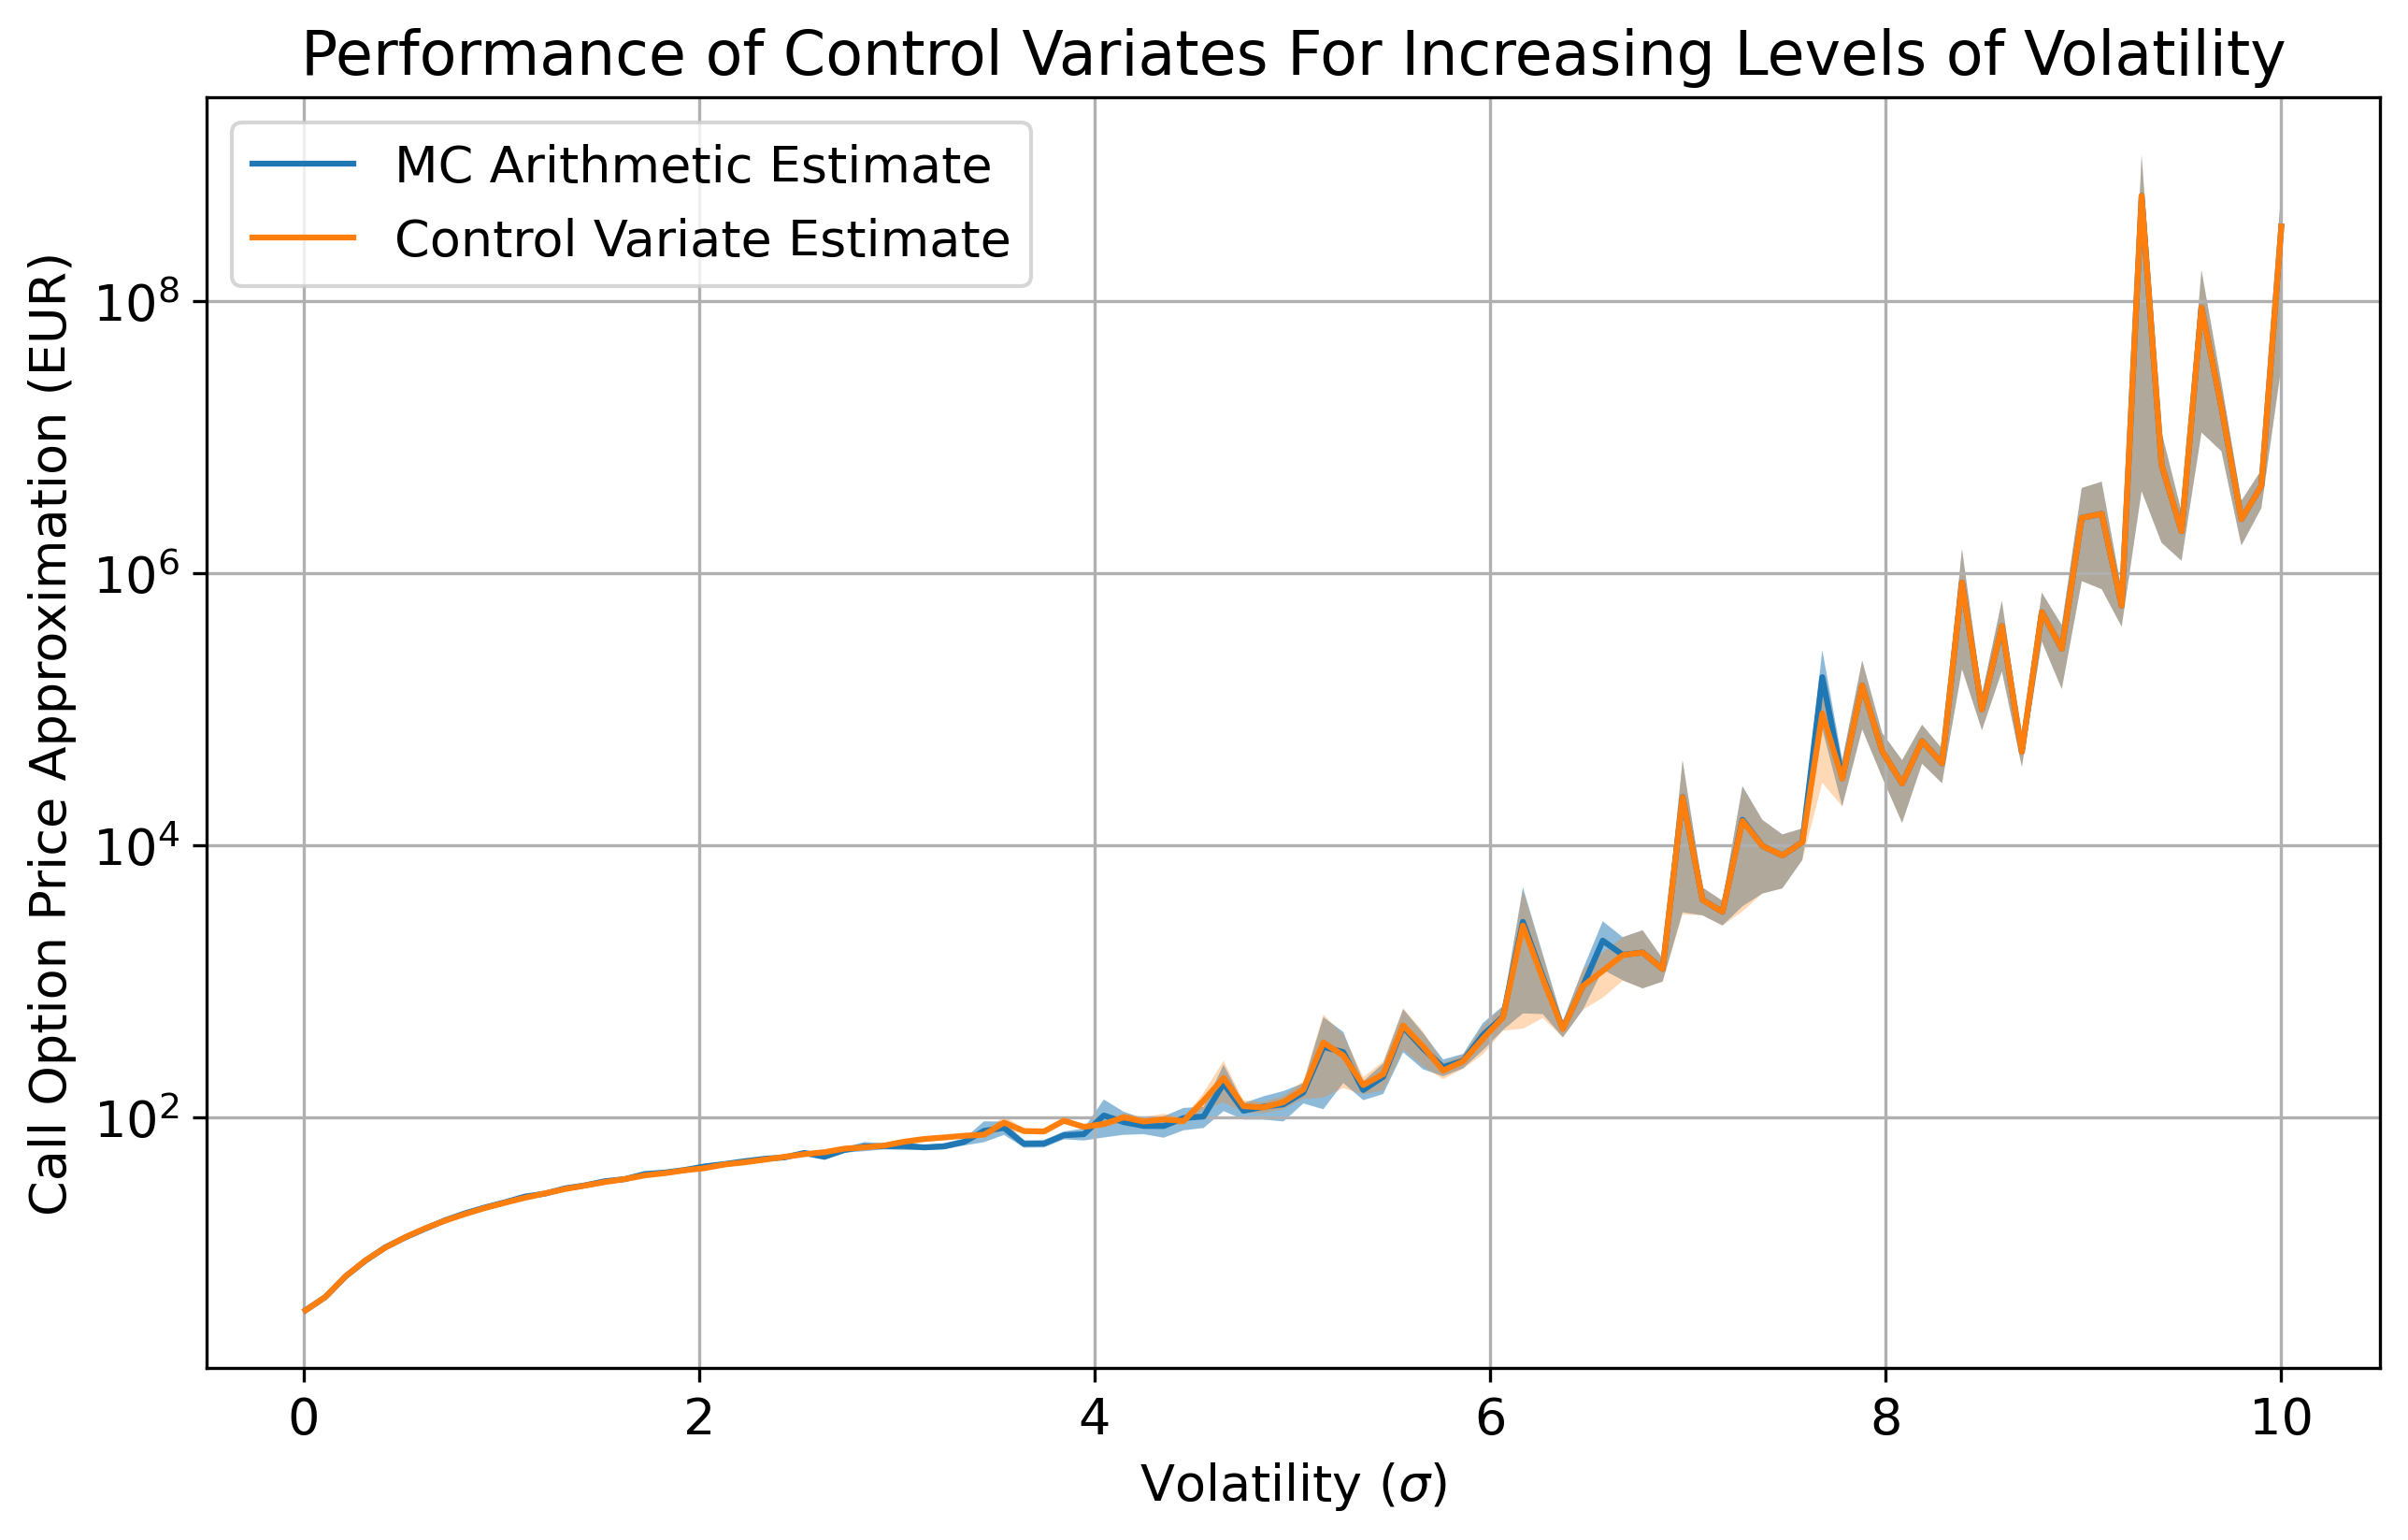

In [329]:
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
ax.plot(sigma_values, sigma_estimates_MC, label='MC Arithmetic Estimate')
ax.plot(sigma_values, sigma_estimates_c, label='Control Variate Estimate')
ax.fill_between(sigma_values, sigma_estimates_MC - sigma_estimates_MC_se, sigma_estimates_MC + sigma_estimates_MC_se, alpha = 0.5)
ax.fill_between(sigma_values, sigma_estimates_c - sigma_estimates_c_se, sigma_estimates_c + sigma_estimates_c_se, alpha = 0.3)
plt.xlabel(r"Volatility ($\sigma$)")
plt.ylabel("Call Option Price Approximation (EUR)")
plt.title("Performance of Control Variates For Increasing Levels of Volatility")
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [341]:
diff = np.zeros(len(sigma_estimates_c))
for i in range(len(sigma_estimates_c)):
    if sigma_values[i] <= 2:
        diff[i] = (np.abs(sigma_estimates_c[i] - sigma_estimates_MC[i]) / sigma_estimates_c[i]) *100

print(diff)
print(max(diff))

[0.02806448 0.16623235 0.14817781 0.59175271 0.57344879 0.40095172
 0.58830864 0.5120576  1.18394789 0.87319875 0.64753361 2.01164927
 0.40871421 1.09132864 0.2711482  1.42668236 0.1169031  2.33938196
 1.03581081 0.52351979 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       